In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
df_future = pd.read_csv('Final_data.csv').drop(columns=["CPI","Population Estimate"])

In [3]:
df_future.head(5)

,Date,Median Annual Income,Petrol Price,Diesel Price,Google Search Index,All Cars,ULEV,Grants,Charging Points
0,2011-10-31,26719.28962,1.3473,1.4027,23.0,206427.0,31.0,0.0,0.0
1,2011-11-30,26652.97814,1.3317,1.4110,22.0,207544.0,31.0,0.0,0.0
2,2011-12-31,26584.45628,1.3241,1.4077,12.0,208700.0,31.0,0.0,0.0
3,2012-01-31,26515.93443,1.3410,1.4245,21.0,209690.0,31.0,0.0,0.0
4,2012-02-29,26451.83333,1.3621,1.4392,26.0,210618.0,33.0,0.0,0.0


In [4]:
df_future['Date']=pd.to_datetime(df_future['Date'])

In [5]:
df_future.set_index('Date', inplace=True)

In [6]:
df_future.isna().sum()

Median Annual Income    68
Petrol Price            65
Diesel Price            65
Google Search Index     65
All Cars                72
ULEV                    65
Grants                  65
Charging Points         65
dtype: int64

In [7]:
df=df_future.dropna()

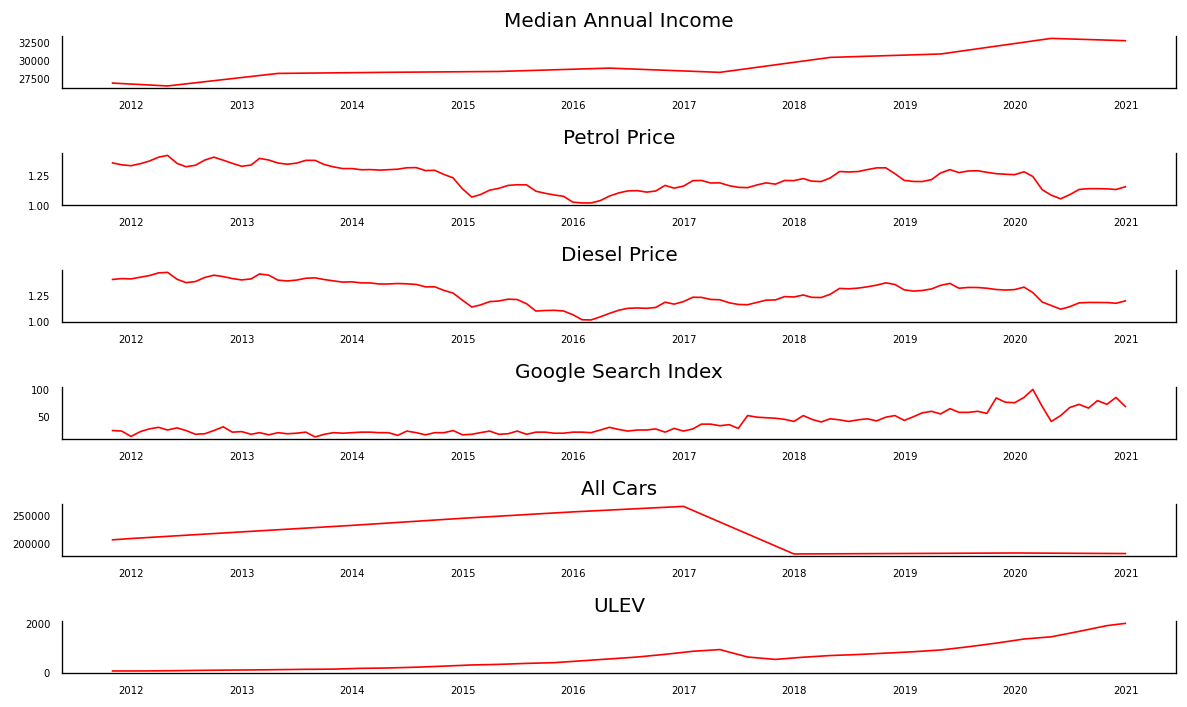

In [8]:
fig, axes = plt.subplots(nrows=6, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [9]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)        


,Median Annual Income_x,Petrol Price_x,Diesel Price_x,Google Search Index_x,All Cars_x,ULEV_x,Grants_x,Charging Points_x
Median Annual Income_y,1.0000,0.0013,0.0041,0.0000,0.0000,0.0121,0.0047,0.0003
Petrol Price_y,0.0639,1.0000,0.0525,0.2123,0.3445,0.2109,0.0918,0.3612
Diesel Price_y,0.2540,0.3312,1.0000,0.1988,0.1441,0.2902,0.0236,0.3320
Google Search Index_y,0.0001,0.0038,0.0059,1.0000,0.0293,0.0001,0.0000,0.0000
All Cars_y,0.0000,0.0001,0.0000,0.0026,1.0000,0.0000,0.0001,0.0001
ULEV_y,0.0001,0.1496,0.0154,0.0334,0.0000,1.0000,0.1058,0.0000
Grants_y,0.2978,0.0000,0.0000,0.0000,0.0000,0.0983,1.0000,0.0000
Charging Points_y,0.2389,0.0000,0.0000,0.0000,0.0000,0.0908,0.0000,1.0000


In [10]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Median Annual Income ::  287.88    > 143.6691  =>   True
Petrol Price ::  201.77    > 111.7797  =>   True
Diesel Price ::  147.17    > 83.9383   =>   True
Google Search Index ::  99.18     > 60.0627   =>   True
All Cars ::  60.65     > 40.1749   =>   True
ULEV   ::  30.43     > 24.2761   =>   True
Grants ::  6.49      > 12.3212   =>   False
Charging Points ::  0.06      > 4.1296    =>   False


In [11]:
df.shape

(111, 8)

In [12]:
nobs = 18
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(93, 8)
(18, 8)


In [13]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    


In [14]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Median Annual Income" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.4762
 No. Lags Chosen       = 1
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.8966. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Petrol Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5951
 No. Lags Chosen       = 2
 Critical value 1%     = -3.505
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.4861. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Diesel Price" 
    -----------------------------------------------
 N

In [15]:
#1st differentiation
df_differenced = df_train.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Median Annual Income" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.0013
 No. Lags Chosen       = 12
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.7528. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Petrol Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.9879
 No. Lags Chosen       = 1
 Critical value 1%     = -3.505
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Diesel Price" 
    -----------------------------------------------
 Null Hypothesis: Data has

In [16]:
#2nd differentiation
df_differenced = df_differenced.diff().dropna()
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Median Annual Income" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.2743
 No. Lags Chosen       = 11
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Petrol Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.474
 No. Lags Chosen       = 9
 Critical value 1%     = -3.514
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Diesel Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary

In [17]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  28.80746941464177
BIC :  30.80731715090598
FPE :  3260282546767.279
HQIC:  29.61392557528118 

Lag Order = 2
AIC :  28.832257643326663
BIC :  32.63511771392859
FPE :  3452990105364.8315
HQIC:  30.365081406072974 

Lag Order = 3
AIC :  28.03307516295683
BIC :  33.66338610495276
FPE :  1699993181446.3228
HQIC:  30.301386111188165 

Lag Order = 4
AIC :  27.56433335151747
BIC :  35.047089021917586
FPE :  1287121446374.974
HQIC:  30.577408317882742 

Lag Order = 5
AIC :  26.473558824151212
BIC :  35.83432525637389
FPE :  615591001226.2427
HQIC:  30.240833639432914 

Lag Order = 6
AIC :  24.368040702906043
BIC :  35.63297355636727
FPE :  139186163964.49493
HQIC:  28.899111775957785 

Lag Order = 7
AIC :  23.233202003198265
BIC :  36.42906462549054
FPE :  131128466647.70331
HQIC:  28.53782770298223 



C:\Users\anich\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [18]:
model_fitted = model.fit(4)
model_fitted.summary()
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col,':', round(val, 2))

Median Annual Income : 1.8
Petrol Price : 2.0
Diesel Price : 2.05
Google Search Index : 2.12
All Cars : 1.79
ULEV : 2.22
Grants : 1.98
Charging Points : 1.94


In [19]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 3

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[ 3.92877000e+00,  1.68000000e-02,  9.30000000e-03,
        -4.00000000e+00,  7.00000000e+00,  3.00000000e+00,
         2.49584027e+03,  0.00000000e+00],
       [-1.30959000e+00,  3.92000000e-02,  1.96000000e-02,
        -8.00000000e+00, -2.00000000e+00, -1.00000000e+00,
        -8.31946755e+02,  0.00000000e+00],
       [ 1.45950030e+02, -2.75000000e-02, -1.60000000e-02,
         1.50000000e+01,  3.00000000e+00,  2.00000000e+01,
         8.31946755e+02,  0.00000000e+00],
       [-5.97540000e+00, -5.26000000e-02, -6.49000000e-02,
        -1.70000000e+01, -3.00000000e+00, -2.00000000e+00,
        -8.31946755e+02,  0.00000000e+00]])

In [20]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Median Annual Income_2d,Petrol Price_2d,Diesel Price_2d,Google Search Index_2d,All Cars_2d,ULEV_2d,Grants_2d,Charging Points_2d
Date,,,,,,,,
2019-07-31,6.482119,0.033364,0.044794,9.271601,1528.047209,3.968594,4375.443904,0.449625
2019-08-31,-45.336487,0.031124,0.033520,-6.597526,-1709.885042,8.651716,-2722.390864,-0.174325
2019-09-30,48.268225,0.012171,-0.002652,11.887836,1258.666178,2.306988,4373.443159,0.161514
2019-10-31,-39.340822,-0.019812,-0.019119,-12.552860,-414.920975,3.741237,-3112.705122,-0.113853
2019-11-30,0.164301,-0.012953,-0.003911,6.459373,623.087958,8.866741,1932.351642,0.236619
2019-12-31,26.064249,-0.003611,-0.009242,-3.361193,-1005.849402,-12.309086,-924.526505,0.000185
2020-01-31,-16.018029,0.025846,0.023325,1.699377,580.182930,12.318515,2289.215771,0.086513
2020-02-29,-6.947221,-0.011219,-0.010172,1.666918,-292.261958,-9.221452,-961.119692,-0.167283
2020-03-31,9.591161,0.004919,0.004462,-1.979742,633.690988,9.407729,1069.822475,0.234303


In [21]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

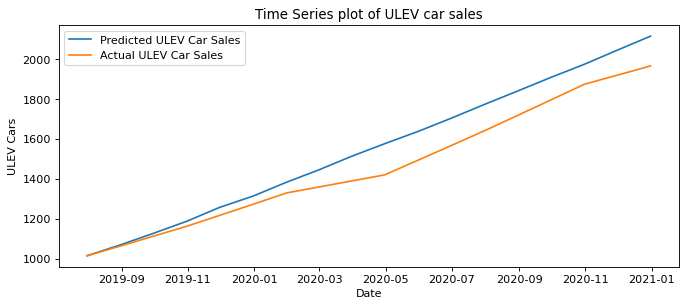

In [22]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['ULEV_forecast']]
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10,4), dpi=80)
plt.plot((df_results["ULEV_forecast"]).astype(int))
plt.plot(df_test["ULEV"][-nobs:])
plt.xlabel("Date")
plt.ylabel("ULEV Cars")
plt.title("Time Series plot of ULEV car sales")
plt.legend(['Predicted ULEV Car Sales', 'Actual ULEV Car Sales'])

In [23]:
preds=(df_results["ULEV_forecast"]).astype(int)
y_values=df["ULEV"][-18:]

In [24]:
import sklearn.metrics as sm
print("R2 score =", round(sm.r2_score(y_values, preds), 2))
print("Mean absolute error =", round(sm.mean_absolute_error(y_values, preds), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_values, preds), 2))

R2 score = 0.88
Mean absolute error = 87.06
Mean squared error = 10355.5


PREDICTING ULEV CAR SALES till 2026:

In [25]:
fc = model_fitted.forecast(y=forecast_input, steps=90)
df_forecast_2027 = pd.DataFrame(fc, index=df_future.index[-90:], columns=df_future.columns + '_2d')
df_results = invert_transformation(df_train, df_forecast_2027, second_diff=True)        
df_results['ULEV_forecast']


Date
2019-07-31    1015.968594
2019-08-31    1070.588904
2019-09-30    1127.516202
2019-10-31    1188.184737
2019-11-30    1257.720013
                 ...     
2026-08-31    8509.576035
2026-09-30    8627.517926
2026-10-31    8746.153227
2026-11-30    8865.481275
2026-12-31    8985.502621
Name: ULEV_forecast, Length: 90, dtype: float64

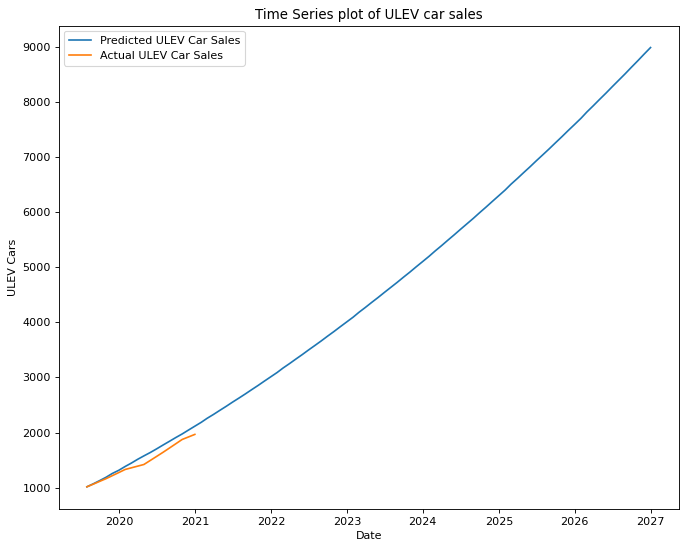

In [26]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)
plt.plot((df_results["ULEV_forecast"]).astype(int))
plt.plot(df_test["ULEV"][-nobs:])
plt.xlabel("Date")
plt.ylabel("ULEV Cars")
plt.title("Time Series plot of ULEV car sales")
plt.legend(['Predicted ULEV Car Sales', 'Actual ULEV Car Sales'])


In [27]:
charging_points_240_grants=df_results["ULEV_forecast"].astype(int)

In [28]:
charging_points_240_grants.to_csv("charging_points_240_grants.csv")